# Data Pre-processing


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
data = pd.read_csv('../Data/train_data.csv', index_col='Claim Identifier')


C:\Users\isa\AppData\Local\Temp\ipykernel_16096\1307583070.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../Data/train_data.csv', index_col='Claim Identifier')


_____

# Empty rows
In the initial analysis we saw that the only features that has no missing values is `_Assembly Date_`. So let's check how many rows only have that feature filled and the rest of columns empty

In [6]:
data.drop(columns=['Assembly Date']).isna().all(axis=1).sum()


19445

In [7]:
df = data[~(data.drop(columns=['Assembly Date']).isna().all(axis=1) & data['Assembly Date'].notna())]

In [8]:
df.drop(columns=['Assembly Date']).isna().all(axis=1).sum()


0

Here 19445 empty rows were dropped

_____

# Overlook of the features
This notebook will include pre processing of the following variables:
- Carrier Name 
- Attorney Representative
- OIICS Nature of Injury Description
- Industry Code
- Medical Fee Region
- C-2 Date
- First Hearing Date
- WCIO Cause of Injury Code
- WCIO Part of Body Code
- WCIO Cause of Injury Description
- WCIO Nature of Injury Description

Since we dropped some rows in the previous section we should check again for the updated number of missing values for the features we are interest in

In [9]:
target_features = ['Carrier Name', 'Attorney/Representative', 'OIICS Nature of Injury Description', 
                   'Industry Code', 'Medical Fee Region', 'C-2 Date', 'First Hearing Date','WCIO Cause of Injury Code',
                   'WCIO Part Of Body Code','WCIO Cause of Injury Description','WCIO Nature of Injury Description']

In [10]:
df[target_features].isnull().sum()/df.shape[0]*100

Carrier Name                            0.000000
Attorney/Representative                 0.000000
OIICS Nature of Injury Description    100.000000
Industry Code                           1.734765
Medical Fee Region                      0.000000
C-2 Date                                2.536470
First Hearing Date                     73.729761
WCIO Cause of Injury Code               2.724615
WCIO Part Of Body Code                  2.975823
WCIO Cause of Injury Description        2.724615
WCIO Nature of Injury Description       2.727577
dtype: float64

The features _`Carrier Name`_,  _`Attorney/Representative`_ and _`Medical Fee Region`_ no longer have missing values. Let's look at the others

### OIICS Nature of Injury Description
Between all the complains this feature is never filled, so we can drop it

In [11]:
# drop OIICS Nature of Injury Description
df = df.drop(columns=['OIICS Nature of Injury Description'])

### First Hearing Date
This feature also has a high percentage of missing values. According to the provided information for this project, 'A blank date means the claim has not yet had a hearing held'. So we should create a label for the ones that hadn't had a hearing yet, we will simply call it 'N/A'

In [12]:
# transform First Hearing Date into pd.datetime
df['First Hearing Date'] = pd.to_datetime(df['First Hearing Date'])

In [13]:
# fill NA with 'N/A'
df['First Hearing Date'] = df['First Hearing Date'].fillna('N/A')
df['First Hearing Date'].isna().sum()

0

To assist in the information that this feature can provide we can create another feature called _`Has First Hearing Date`_ - a binary value that indicates if the user has had it's first hearing date

In [14]:
# create Has First Hearing Date based on if is 'N/A' or not
df['Has First Hearing Date'] = df['First Hearing Date'].apply(lambda x: 0 if x == 'N/A' else 1)

In [15]:
df['Has First Hearing Date'].value_counts()

Has First Hearing Date
0    423228
1    150798
Name: count, dtype: int64

### C-2 Date
I think that there is relationship between this C-2 Date and some other date, ideally _`Assembly Date`_, but I dont know how to prove it yet

In [16]:
date_features = ['Accident Date', 'C-2 Date', 'First Hearing Date', 'Assembly Date']
date_df = df[date_features]

date_df[date_df['C-2 Date'].isna()].head(20)

,Accident Date,C-2 Date,First Hearing Date,Assembly Date
Claim Identifier,,,,
5393991,2019-12-05,NaN,N/A,2020-01-02
5394018,2019-12-11,NaN,2020-09-15 00:00:00,2020-01-02
5394153,2019-08-15,NaN,N/A,2020-01-02
5393971,2019-06-26,NaN,N/A,2020-01-02
5393773,2019-12-27,NaN,N/A,2020-01-02
5393917,2019-09-23,NaN,N/A,2020-01-02
5394102,2019-12-20,NaN,N/A,2020-01-02
5393964,2001-09-12,NaN,N/A,2020-01-02
5393769,2019-11-14,NaN,N/A,2020-01-02


### Codes and Descriptions
This section will analyse data related to codes and their descriptions

In [17]:
df_codes = df[[col for col in df.columns if 'Code' in col]]
df_codes.drop(columns=['Industry Code Description', 'Zip Code'], inplace=True)

df_description = df[[col for col in df.columns if 'Description' in col]]

C:\Users\isa\AppData\Local\Temp\ipykernel_16096\1033338758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_codes.drop(columns=['Industry Code Description', 'Zip Code'], inplace=True)


In [18]:
# ensure that all codes are objects
df_codes = df_codes.astype('object')

df_codes.describe()

,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code
count,564068.0,558386.0,558369.0,556944.0
unique,24.0,77.0,56.0,57.0
top,62.0,56.0,52.0,42.0
freq,114339.0,46610.0,153373.0,51862.0


In [19]:
#check the order of the codes
df_codes.columns


Index(['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')

In [20]:
#check the order of the descriptions
df_description.columns

Index(['Industry Code Description', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'],
      dtype='object')

In [56]:
df[df['WCIO Cause of Injury Code'] == '56.0']['WCIO Cause of Injury Description'].value_counts()

WCIO Cause of Injury Description
lifting    46610
Name: count, dtype: int64

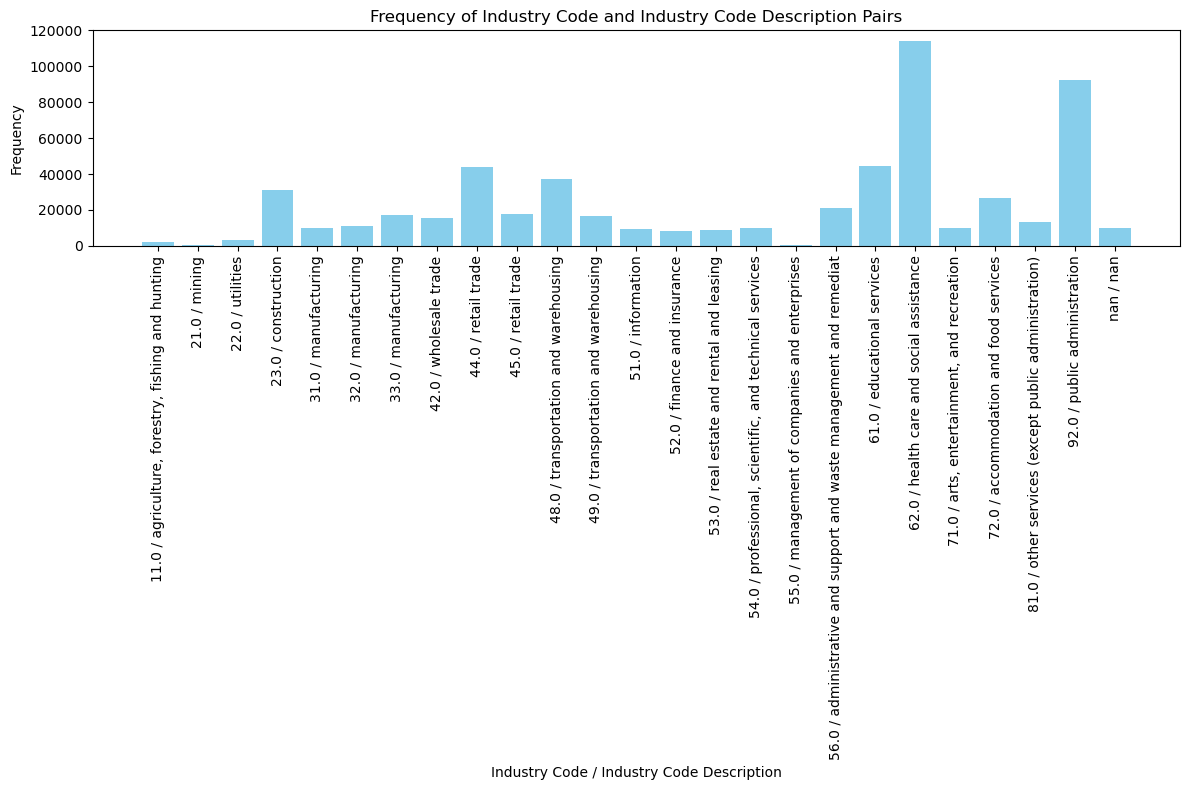

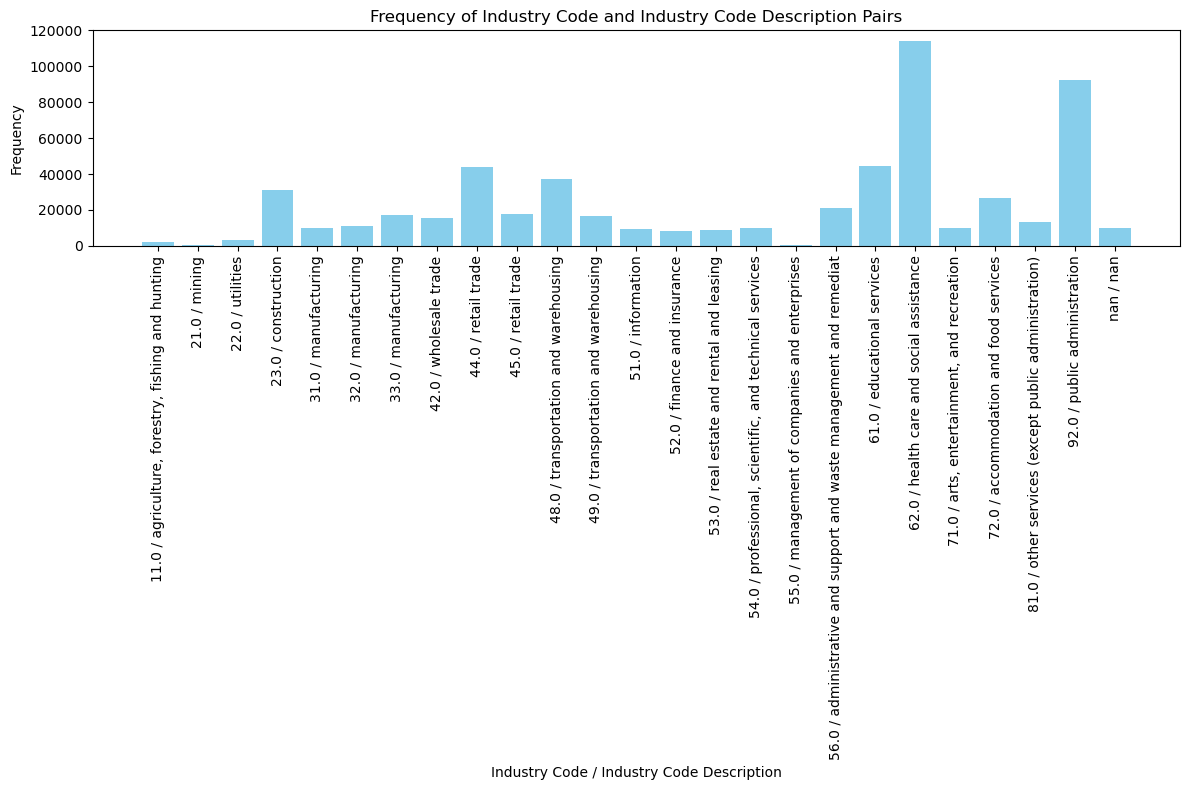

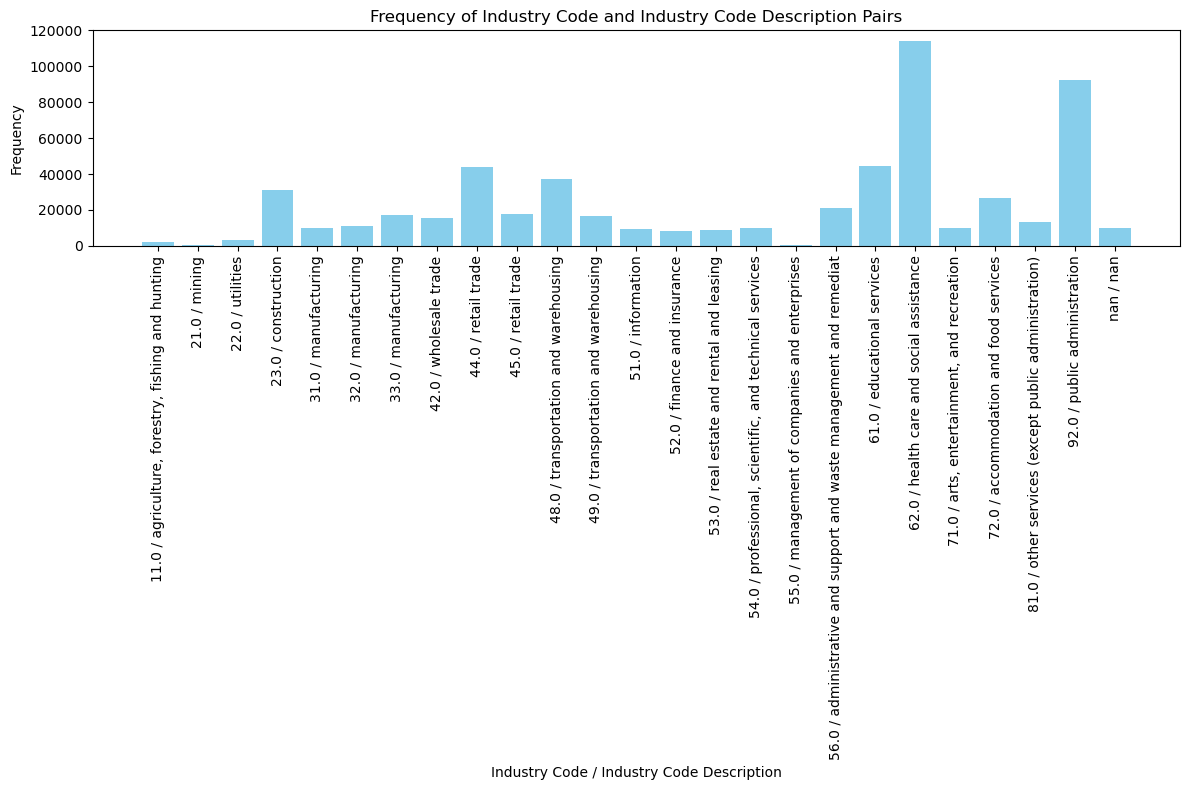

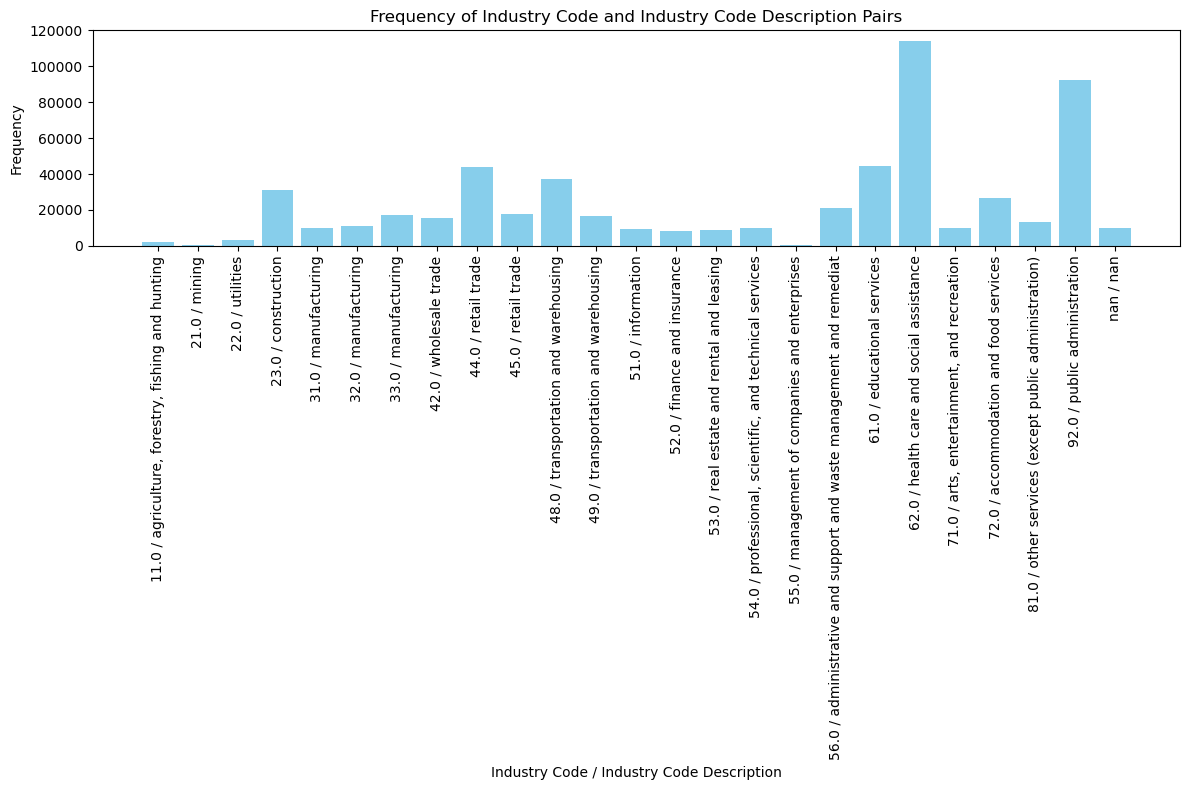

In [57]:
for code_col, desc_col in zip(df_codes.columns, df_description.columns):    
    code_column = 'Industry Code'       # Replace with the code column name in `merged_df`
    description_column = 'Industry Code Description'  # Replace with the description column name

    # Count occurrences of each code/description pair
    code_description_counts = df.groupby([code_column, description_column]).size().reset_index(name='Count').sort_index()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(
        x=code_description_counts[code_column].astype(str) + ' / ' + code_description_counts[description_column],
        height=code_description_counts['Count'],
        color='skyblue'
    )

    # Formatting the plot
    plt.xlabel(f"{code_column} / {description_column}")
    plt.ylabel("Frequency")
    plt.title(f"Frequency of {code_column} and {description_column} Pairs")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()